In [1]:
# Standard scientific Python imports
import matplotlib.pyplot as plt
import numpy as np
import time
import datetime as dt
import mxnet as mx
import d2lzh as d2l
from mxnet import autograd, gluon, init, nd
from mxnet.gluon import nn, data as gdata, loss as gloss 

# Import datasets, classifiers and performance metrics
from sklearn import datasets, svm, metrics
#fetch original mnist dataset
from sklearn.datasets import fetch_openml


# it creates mldata folder in your root project folder
mnist = fetch_openml('mnist_784')

/Users/wenging/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:996: UserWarning: Illegal line #1
	"$ cat ~/.matplotlib/matplotlibrc
"
	in file "/Users/wenging/.matplotlib/matplotlibrc"
  warnings.warn('Illegal %s' % error_details)


In [2]:
#data field is 70k x 784 array, each row represents pixels from 28x28=784 image
images = mnist.data
targets = mnist.target

In [3]:
#full dataset classification
X = images/255.0
Y = targets

In [4]:
Features = mx.nd.array(X)
Labels = mx.nd.array(Y)

# Master-Worker NN

In [5]:
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 120
import matplotlib.pyplot as plt

# update function
def sgd(params, hyperparams, grads): 
    for p, g in zip(params, grads):
        p[:] -= hyperparams['lr'] * g
            
def trainer(hyperparams, features, labels,
batch_size, num_epochs, layers):# Initialization
    num_inputs, num_outputs, num_hiddens_1, num_hiddens_2 = features.shape[1], 10, layers[0], layers[1]
    W1 = nd.random.normal(scale=0.01, shape=(num_inputs, num_hiddens_1))
    W2 = nd.random.normal(scale=0.01, shape=(num_hiddens_1, num_hiddens_2))
    W3 = nd.random.normal(scale=0.01, shape=(num_hiddens_2, num_outputs))
    params = [W1, W2, W3] 
    
    # gradients store buffer for workers
    g1 = nd.zeros(shape=(num_inputs, num_hiddens_1))
    g2 = nd.zeros(shape =(num_hiddens_1, num_hiddens_2))
    g3 = nd.zeros(shape =(num_hiddens_2, num_outputs))
    
    # SoftmaxCrossEntropyLoss
    loss_function = gluon.loss.SoftmaxCrossEntropyLoss()
    
    for param in params:
        param.attach_grad()
    
    def relu(X):
        return nd.relu(X)
    
    def net(X):
        X = X.reshape((-1, num_inputs))
        H1 = nd.relu(nd.dot(X, W1))
        H2 = nd.relu(nd.dot(H1, W2))
        return nd.dot(H2, W3)
   
    #total_loss = [np.mean(loss_function(net(features), labels).asnumpy())]
    total_loss = []
    data_iter = gdata.DataLoader(gdata.ArrayDataset(features, labels), batch_size, shuffle=False) 
    for _ in range(num_epochs):
        # each epoch clean the gradients buffer
        g1, g2, g3 = nd.zeros(shape=(num_inputs, num_hiddens_1)), nd.zeros(shape =(num_hiddens_1, num_hiddens_2)), nd.zeros(shape =(num_hiddens_2, num_outputs))
        for batch_i, (data, label) in enumerate(data_iter):
            with autograd.record():
                output = net(data)
                loss = loss_function(output, label).mean()
            loss.backward()
            # store the worker gradients
            g1 += W1.grad; g2 += W2.grad; g3 += W3.grad;
        
        # Master update the model weights 
        g1_m, g2_m, g3_m = g1/6, g2/6, g3/6;
        sgd([W1, W2, W3], hyperparams, [g1_m, g2_m, g3_m])
        
        l = np.mean(loss_function(net(features), labels).asnumpy())
        print(l)
        total_loss.append(np.mean(loss_function(net(features), labels).asnumpy())) 
    print(type(W1.asnumpy()))
    print(type(W1.asnumpy().shape))
    print('w1:', np.reshape(W1.asnumpy(), (1, -1)),
          'w2:', np.reshape(W2.asnumpy(), (1, -1)),
          'w3:', np.reshape(W3.asnumpy(), (1, -1)),'\n')
    x_axis = np.linspace(0, num_epochs, len(total_loss), endpoint=True)
    plt.semilogy(x_axis, total_loss)
    plt.xlabel('epoch')
    plt.ylabel('loss')

2.3025322
2.3025033
2.3024735
2.3024433
2.3024118
2.30238
2.3023465
2.3023121
2.3022761
2.3022387
2.3021994
2.302158
2.3021145
2.3020682
2.3020184
2.3019652
2.301908
2.3018463
2.301779
2.3017056
2.3016257
2.3015373
2.30144
2.301333
2.3012142
2.3010836
2.3009386
2.300778
2.3005984
2.3003974
2.3001707
2.2999146
2.2996228
2.299289
2.2989054
2.2984612
2.2979436
2.2973356
2.296617
2.2957597
2.2947276
2.293473
2.2919316
2.2900167
2.287608
2.2845383
2.2805765
2.2753994
2.268559
2.2594547
2.2473352
2.231393
2.2110736
2.1866598
2.159756
2.1326933
2.1065428
2.080135
2.0509481
2.0156343
<class 'numpy.ndarray'>
<class 'tuple'>
w1: [[ 0.01163079  0.00483805  0.00299563 ... -0.0084357  -0.00083969
  -0.01933733]] w2: [[-0.01228482  0.013117   -0.00489369 ...  0.02280896  0.00075737
  -0.01328025]] w3: [[ 1.38802230e-01 -8.42820406e-02  8.28004405e-02  9.58758295e-02
  -9.34500694e-02  2.11024210e-02  3.72569524e-02 -1.10189594e-01
   2.67729107e-02 -9.93585363e-02 -1.35747856e-02  3.98221985e-02
   

CPU times: user 3min 59s, sys: 7.43 s, total: 4min 6s
Wall time: 1min


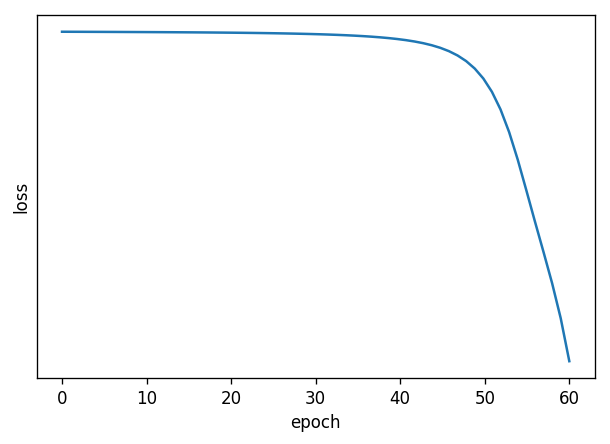

In [6]:
# Total data is 60000 divide into 6 groups each batch is 10000
%time trainer({'lr': 0.5}, Features, Labels, batch_size=10000, num_epochs=60, layers=[128,64])
plt.savefig('m-6w.png')

# 2-Star NN

In [7]:
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 120
import matplotlib.pyplot as plt

# update function
def sgd(params, hyperparams, grads): 
    for p, g in zip(params, grads):
        p[:] -= hyperparams['lr'] * g
            
def trainer_2star(hyperparams, features, labels,
batch_size, num_epochs, layers):# Initialization
    num_inputs, num_outputs, num_hiddens_1, num_hiddens_2 = features.shape[1], 10, layers[0], layers[1]
    W1 = nd.random.normal(scale=0.01, shape=(num_inputs, num_hiddens_1))
    W2 = nd.random.normal(scale=0.01, shape=(num_hiddens_1, num_hiddens_2))
    W3 = nd.random.normal(scale=0.01, shape=(num_hiddens_2, num_outputs))
    params = [W1, W2, W3] 
    
    # gradients store buffer at worker 3 for workers 1&2
    g3_1 = nd.zeros(shape=(num_inputs, num_hiddens_1))
    g3_2 = nd.zeros(shape =(num_hiddens_1, num_hiddens_2))
    g3_3 = nd.zeros(shape =(num_hiddens_2, num_outputs))
    
    # gradients store buffer at worker 4 for workers 5&6
    g4_1 = nd.zeros(shape=(num_inputs, num_hiddens_1))
    g4_2 = nd.zeros(shape =(num_hiddens_1, num_hiddens_2))
    g4_3 = nd.zeros(shape =(num_hiddens_2, num_outputs))
    
    # SoftmaxCrossEntropyLoss
    loss_function = gluon.loss.SoftmaxCrossEntropyLoss()
    
    for param in params:
        param.attach_grad()
    
    def relu(X):
        return nd.relu(X)
    
    def net(X):
        X = X.reshape((-1, num_inputs))
        H1 = nd.relu(nd.dot(X, W1))
        H2 = nd.relu(nd.dot(H1, W2))
        return nd.dot(H2, W3)
   
    #total_loss = [np.mean(loss_function(net(features), labels).asnumpy())]
    total_loss = []
    data_iter = gdata.DataLoader(gdata.ArrayDataset(features, labels), batch_size, shuffle=False) 
    for _ in range(num_epochs):
        # each epoch clean the gradients buffer
        g3_1, g3_2, g3_3 = nd.zeros(shape=(num_inputs, num_hiddens_1)), nd.zeros(shape =(num_hiddens_1, num_hiddens_2)), nd.zeros(shape =(num_hiddens_2, num_outputs))
        g4_1, g4_2, g4_3 = nd.zeros(shape=(num_inputs, num_hiddens_1)), nd.zeros(shape =(num_hiddens_1, num_hiddens_2)), nd.zeros(shape =(num_hiddens_2, num_outputs))
        i = 1
        for batch_i, (data, label) in enumerate(data_iter):
            with autograd.record():
                output = net(data)
                loss = loss_function(output, label).mean()
            loss.backward()
            # store the worker gradients
            if i <= 2: g3_1 += W1.grad; g3_2 += W2.grad; g3_3 += W3.grad;
            else: g4_1 += W1.grad; g4_2 += W2.grad; g4_3 += W3.grad;
        
        # Master update the model weights 
        g_m =[]
        for i, j in zip([g3_1, g3_2, g3_3], [g4_1, g4_2, g4_3]):
            g_m.append(i/2 + j/2)
        sgd([W1, W2, W3], hyperparams, g_m)
        
        l = np.mean(loss_function(net(features), labels).asnumpy())
        print(l)
        total_loss.append(np.mean(loss_function(net(features), labels).asnumpy())) 
    print(type(W1.asnumpy()))
    print(type(W1.asnumpy().shape))
    print('w1:', np.reshape(W1.asnumpy(), (1, -1)),
          'w2:', np.reshape(W2.asnumpy(), (1, -1)),
          'w3:', np.reshape(W3.asnumpy(), (1, -1)),'\n')
    x_axis = np.linspace(0, num_epochs, len(total_loss), endpoint=True)
    plt.semilogy(x_axis, total_loss)
    plt.xlabel('epoch')
    plt.ylabel('loss')

2.302625
2.3026
2.3025749
2.30255
2.3025248
2.3024995
2.302474
2.302448
2.3024216
2.3023946
2.302366
2.3023374
2.3023074
2.3022761
2.3022435
2.302209
2.3021727
2.3021348
2.3020947
2.302052
2.3020067
2.3019586
2.3019068
2.3018515
2.3017921
2.3017285
2.30166
2.301586
2.3015056
2.301419
2.3013244
2.301221
2.3011086
2.3009849
2.300849
2.3006992
2.3005335
2.3003495
2.3001447
2.2999156
2.299659
2.2993693
2.2990422
2.29867
2.298245
2.2977571
2.2971938
2.2965395
2.295775
2.2948754
2.2938101
2.2925384
2.2910094
2.2891562
2.2868934
2.2841067
2.2806509
2.276342
2.2709506
2.2642162
<class 'numpy.ndarray'>
<class 'tuple'>
w1: [[ 0.00411937  0.00570394 -0.00380902 ... -0.01208223  0.00573558
  -0.00616928]] w2: [[-0.00636928  0.00104005  0.0010179  ... -0.00412273  0.01006407
   0.00596016]] w3: [[-8.45009275e-03 -1.46202017e-02 -1.47077581e-02 -9.80989571e-05
   2.76655401e-03  1.25276251e-03 -9.44919884e-03  1.31886778e-02
   3.47730750e-03 -1.46275992e-02 -1.49646159e-02  1.52253378e-02
  -1.4324

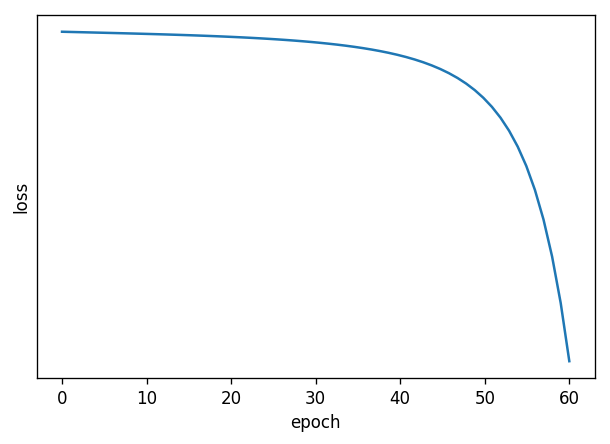

In [8]:
# Total data is 60000 divide into 4 groups each batch is 15000
%time trainer_2star({'lr': 0.2}, Features, Labels, batch_size=15000, num_epochs=60, layers=[128,64])
plt.savefig('2star.png')

# Regularization

In [9]:
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 120
import matplotlib.pyplot as plt

# update function
def sgd(params, hyperparams): 
    for p in params:
        p[:] -= hyperparams['lr'] * p.grad
            
def trainer_l1(hyperparams, features, labels,
batch_size, num_epochs, layers):# Initialization
    num_inputs, num_outputs, num_hiddens_1, num_hiddens_2 = features.shape[1], 10, layers[0], layers[1]
    W1 = nd.random.normal(scale=0.01, shape=(num_inputs, num_hiddens_1))
    W2 = nd.random.normal(scale=0.01, shape=(num_hiddens_1, num_hiddens_2))
    W3 = nd.random.normal(scale=0.01, shape=(num_hiddens_2, num_outputs))
    params = [W1, W2, W3] 
    
    # SoftmaxCrossEntropyLoss
    loss_function = gluon.loss.SoftmaxCrossEntropyLoss()
    #loss_function = gluon.loss.L2Loss()
    
    for param in params:
        param.attach_grad()
    
    def net(X):
        X = X.reshape((-1, num_inputs))
        H1 = nd.relu(nd.dot(X, W1))
        H2 = nd.relu(nd.dot(H1, W2))
        return nd.dot(H2, W3)
   
    total_loss = [np.mean(loss_function(net(features), labels).asnumpy())]
    data_iter = gdata.DataLoader(gdata.ArrayDataset(features, labels), batch_size, shuffle=False) 
    for _ in range(num_epochs):
        for batch_i, (data, label) in enumerate(data_iter):
            with autograd.record():
                output = net(data)
                l1 = mx.nd.abs(W1).mean() + mx.nd.abs(W2).mean() + mx.nd.abs(W3).mean()
                loss = loss_function(output, label).mean() + l1/3
            loss.backward()
            sgd([W1, W2, W3], hyperparams) # Update Model Params

            l = np.mean(loss_function(net(features), labels).asnumpy())
            print(l)
            total_loss.append(np.mean(loss_function(net(features), labels).asnumpy()))
            
    print(type(W1.asnumpy()))
    print(type(W1.asnumpy().shape))
    print('w1:', np.reshape(W1.asnumpy(), (1, -1)),
          'w2:', np.reshape(W2.asnumpy(), (1, -1)),
          'w3:', np.reshape(W3.asnumpy(), (1, -1)),'\n')
    x_axis = np.linspace(0, num_epochs, len(total_loss), endpoint=True)
    plt.semilogy(x_axis, total_loss)
    plt.xlabel('epoch')
    plt.ylabel('loss')

2.3026109
2.302607
2.302603
2.302599
2.302595
2.3025908
2.3025866
2.302583
2.3025794
2.3025758
2.3025715
2.302568
2.3025646
2.3025613
2.302558
2.3025553
2.3025517
2.302549
2.3025458
2.3025422
2.3025393
2.302536
2.302533
2.3025298
2.302527
2.3025239
2.302521
2.3025181
2.3025148
2.3025122
2.3025093
2.3025072
2.3025048
2.3025017
2.302499
2.3024964
2.3024936
2.3024912
2.3024883
2.302486
2.3024836
2.3024812
2.3024786
2.3024764
2.302474
2.3024719
2.3024695
2.3024669
2.3024642
2.3024626
2.3024602
2.3024578
2.302456
2.3024535
2.302451
2.3024487
2.3024464
2.3024442
2.3024423
2.3024395
2.3024378
2.3024364
2.3024344
2.3024325
2.3024306
2.3024282
2.302426
2.302424
2.302421
2.302419
2.302417
2.3024151
2.3024132
2.302411
2.3024094
2.302407
2.3024049
2.3024037
2.3024015
2.3023999
2.3023977
2.3023956
2.302394
2.3023922
2.3023903
2.302389
2.3023875
2.3023858
2.3023841
2.302382
2.3023798
2.3023784
2.3023765
2.3023748
2.3023736
2.302372
2.3023698
2.3023686
2.3023665
2.3023648
2.3023632
2.3023622
2.302360

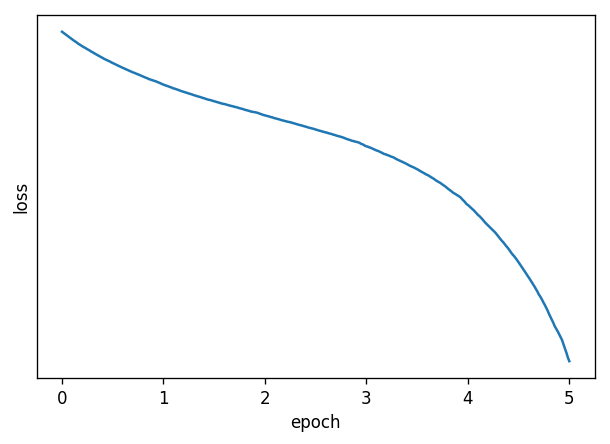

In [10]:
# Power Consumption Data
%time trainer_l1({'lr': 0.1}, Features, Labels, batch_size=1000, num_epochs=5, layers=[128,64])
plt.savefig('mini_l1.png')